# 1. Import and setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [3]:
RANDOM_STATE=42

# 2. Read dataset

In [4]:
df = pd.read_csv('../dataset/digital_phenotype_cohort.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,c_creative_protein,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,lactate_dehydrogenase_LDH,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,earliest_height_cm
0,26100575,0,F,71,NaN,31.3,NaN,28.0,1.2,158.0,...,107.0,13.2,NaN,NaN,NaN,11.0,125.0,60.0,59.7,NaN
1,22698313,0,F,89,2164-09-06T02:23:00,19.9,NaN,40.0,1.0,107.0,...,183.0,16.4,28.0,0.4,265.0,23.0,130.0,40.0,56.0,NaN
2,29562026,0,F,84,NaN,22.5,NaN,26.0,0.7,118.0,...,160.0,17.4,27.0,2.8,317.0,14.0,120.0,50.0,78.1,152.4
3,21607777,0,F,37,NaN,29.5,NaN,31.0,2.0,76.0,...,239.0,15.8,168.0,1.1,347.0,13.0,150.0,40.0,52.2,155.0
4,25233292,0,M,47,NaN,29.9,NaN,97.0,6.8,137.0,...,137.0,12.7,473.0,0.4,666.0,24.0,130.0,50.0,103.4,183.0


In [5]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    339
Dead        63
Name: count, dtype: int64

In [6]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'c_creative_protein', 'blood_urea_nitrogen',
       'serum_creatinine', 'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'Serum_Amylase', 'lipase',
       'white_bloodcells', 'lactate_dehydrogenase', 'Glucose_serum',
       'platelet_PLT', 'Prothrombin_time', 'aminotransferase_ALT',
       'Total_Bilirubin', 'lactate_dehydrogenase_LDH', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'earliest_height_cm', 'mortality'],
      dtype='object')

# 3. Exploratory Data

## 3.1. General Statistics

In [7]:
df.shape

(402, 27)

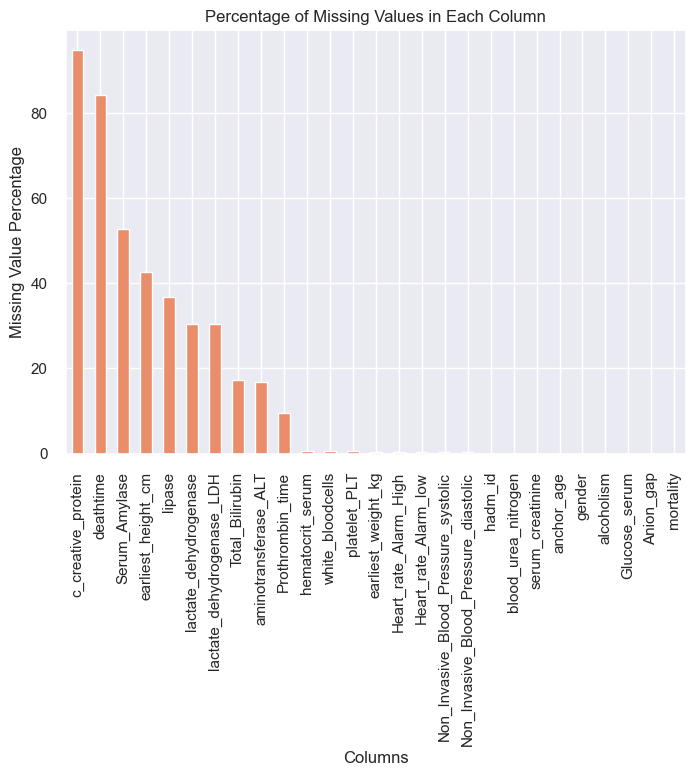

In [8]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [9]:
missing_columns = missing_percentage.sort_values(ascending=False)[:10]
missing_columns

c_creative_protein           94.776119
deathtime                    84.328358
Serum_Amylase                52.736318
earliest_height_cm           42.537313
lipase                       36.815920
lactate_dehydrogenase        30.348259
lactate_dehydrogenase_LDH    30.348259
Total_Bilirubin              17.164179
aminotransferase_ALT         16.915423
Prothrombin_time              9.452736
dtype: float64

In [10]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,26100575,0,F,71,31.3,28.0,1.2,158.0,61.0,4.6,127.0,107.0,11.0,125.0,60.0,59.7,Survive
1,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,23.0,130.0,40.0,56.0,Dead
2,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,14.0,120.0,50.0,78.1,Survive
3,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,13.0,150.0,40.0,52.2,Survive
4,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,24.0,130.0,50.0,103.4,Survive


In [11]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.000000    398
0.117647      1
0.176471      3
Name: count, dtype: int64

In [12]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,402.00,402.00,402.00,400.00,402.00,402.00,401.00,401.00,400.00,402.00,400.00,402.00,401.00,401.00,401.00
mean,24892025.13,0.10,59.83,32.51,30.38,1.83,124.91,70.60,13.15,151.72,226.01,15.51,124.44,52.69,80.07
std,2829286.11,0.31,17.69,7.30,26.65,2.04,26.97,19.97,10.80,113.24,136.68,5.31,9.27,5.64,24.29
min,20009550.00,0.00,21.00,13.40,1.00,0.10,57.00,25.00,0.20,36.00,6.00,5.00,100.00,40.00,32.00
25%,22490368.50,0.00,48.00,27.55,13.00,0.80,106.00,56.00,7.20,98.25,124.00,12.00,120.00,50.00,63.90
50%,24807124.00,0.00,61.00,31.55,22.00,1.10,123.00,69.00,11.10,127.50,204.00,15.00,120.00,50.00,77.00
75%,27306273.25,0.00,72.00,36.80,37.75,2.00,142.00,82.00,16.42,163.75,297.25,17.00,130.00,60.00,92.00
max,29995505.00,1.00,91.00,63.90,163.00,20.40,259.00,142.00,156.20,1390.00,942.00,45.00,170.00,90.00,250.00


In [13]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,402,402
unique,2,2
top,F,Survive
freq,203,339


In [14]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  402
Number of duplication 0


In [15]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg', 'mortality'],
      dtype='object')

In [16]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

## 3.2.  Univariate analysis

#### Distribution of Gender

In [17]:
# Distribution of gender
gender_counts = df['gender'].value_counts()
gender_counts

gender
F    203
M    199
Name: count, dtype: int64

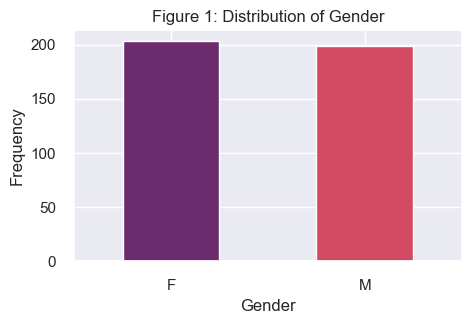

In [18]:
plt.figure(figsize=(5,3))
gender_counts.plot(kind='bar', title='Figure 1: Distribution of Gender', xlabel='Gender', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Alcoholism

In [19]:
# Distribution of comorbidity index
alc_counts = df_clean['alcoholism'].value_counts()
alc_counts

alcoholism
0    360
1     42
Name: count, dtype: int64

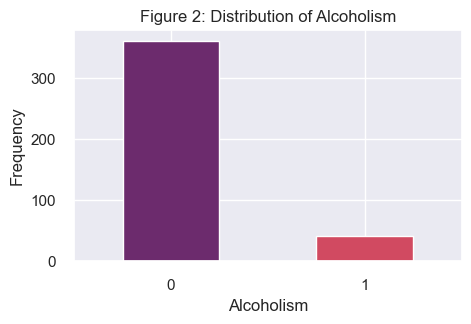

In [20]:
plt.figure(figsize=(5,3))
alc_counts.plot(kind='bar', title='Figure 2: Distribution of Alcoholism', xlabel='Alcoholism', ylabel='Frequency',
                   rot=0, color=[palette[-1], palette[-4]])
plt.show()

#### Anchor age

In [21]:
# Group age by 10 years
bins = list(range(20, 101, 10))
age_groups = pd.cut(df_clean['anchor_age'], bins=bins, right=False)
ageg_counts = age_groups.value_counts().sort_index()

# Grouped age counts
print(ageg_counts)

anchor_age
[20, 30)     27
[30, 40)     32
[40, 50)     53
[50, 60)     71
[60, 70)     96
[70, 80)     62
[80, 90)     47
[90, 100)    14
Name: count, dtype: int64


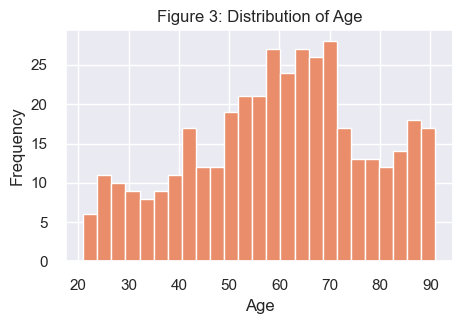

In [22]:
plt.figure(figsize=(5,3))
df_clean['anchor_age'].plot(kind='hist', title='Figure 3: Distribution of Age',ylabel='Frequency',
                      rot=0, bins=25).set_xlabel('Age')
plt.show()

#### Date of death

In [23]:
# Distribution of date of death
dod_counts = df['deathtime'].value_counts(dropna=False)
dod_counts[:10]

deathtime
NaN                    339
2164-09-06T02:23:00      1
2110-09-22T20:55:00      1
2180-07-23T05:44:00      1
2131-07-22T01:17:00      1
2149-07-25T15:00:00      1
2158-09-25T03:59:00      1
2161-09-17T15:43:00      1
2191-01-10T18:55:00      1
2178-03-03T16:00:00      1
Name: count, dtype: int64

In [24]:
print("Number of patients survived is", len(df[df.mortality == 'Survive']))
print(f"Mortality rate is {round(100* len(df[df.mortality == 'Dead']) / len(df),2)}%")

Number of patients survived is 339
Mortality rate is 15.67%


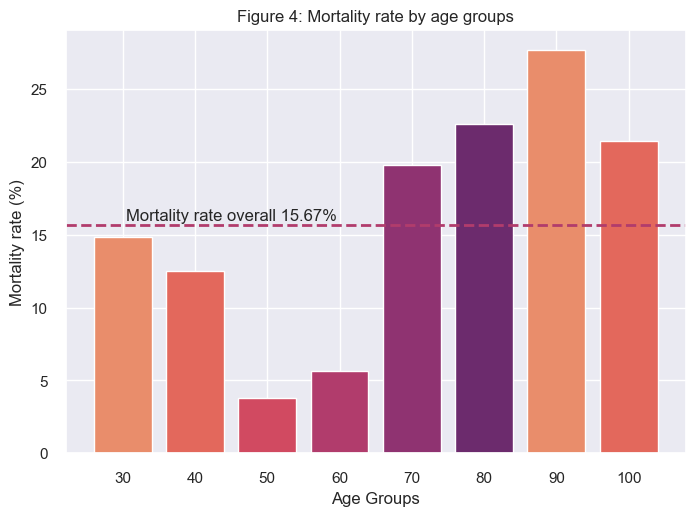

In [25]:
# Mortality rate in each age groups
rate_age = pd.DataFrame(zip(df['mortality'], age_groups), columns=['mortality', 'age_groups'])
total = rate_age.groupby(['age_groups']).count()
rate = pd.DataFrame(rate_age.groupby(['age_groups', 'mortality']).size()).reset_index().drop_duplicates(subset=['age_groups'], keep="first")
mortality_rate = 100 * rate.iloc[:,2].values / total.values[:,0]

plt.bar(["30", "40", "50", "60", "70", "80", "90", "100"], mortality_rate, color=palette)
plt.axhline(y=round(100* len(df[df.mortality == 'Dead']) / len(df),2), color=palette[3], linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Mortality rate overall 15.67%', xy=(0, 20), xytext=(0.05, 16))

plt.xlabel("Age Groups")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 4: Mortality rate by age groups")

plt.show()

Mortality rate drawn from dataset is approximately $15.67\%$. Older people have higher risk of mortality.

#### Others

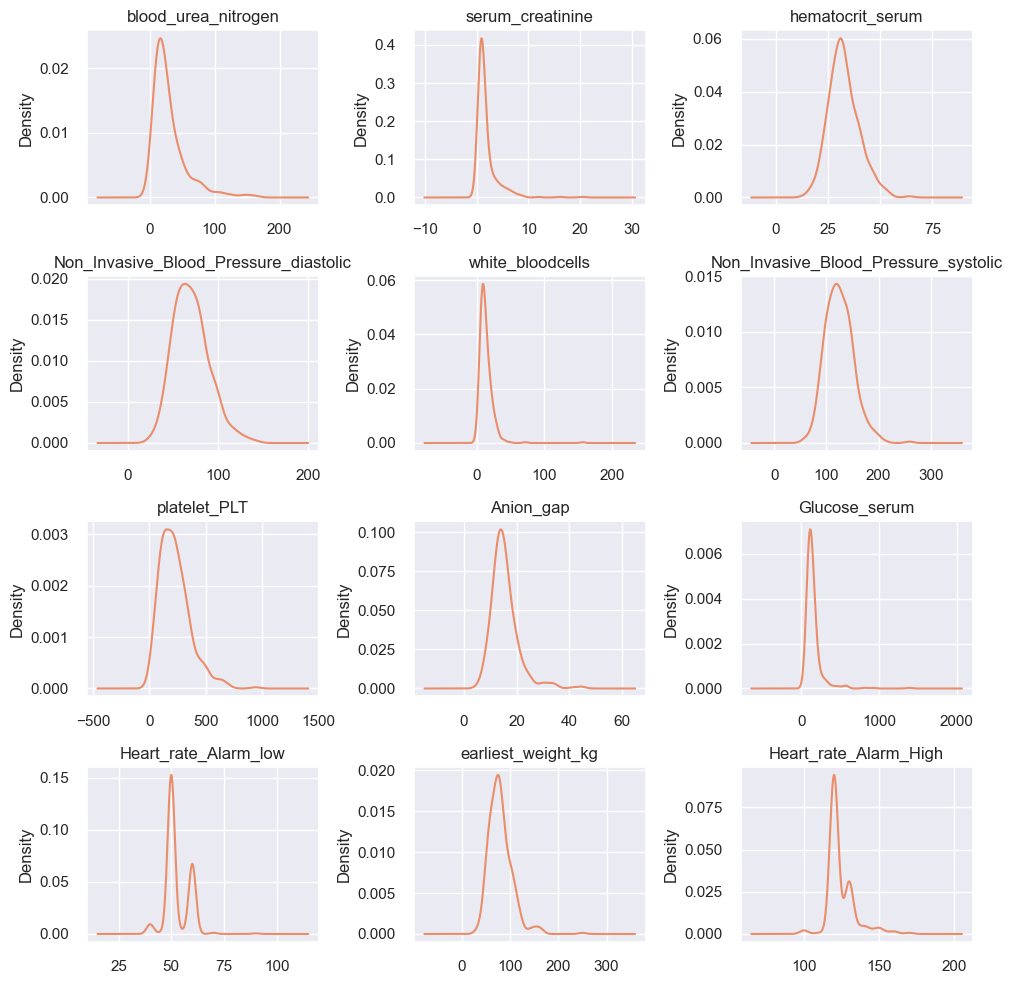

In [26]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

for i, col in enumerate(features_kde):
    df_clean[col].plot(ax=axes[i//3, i%3-1], kind='kde', title=col)
    
plt.tight_layout()
plt.show()

## 3.3. Multivariate analysis

#### Helper function

In [27]:
"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

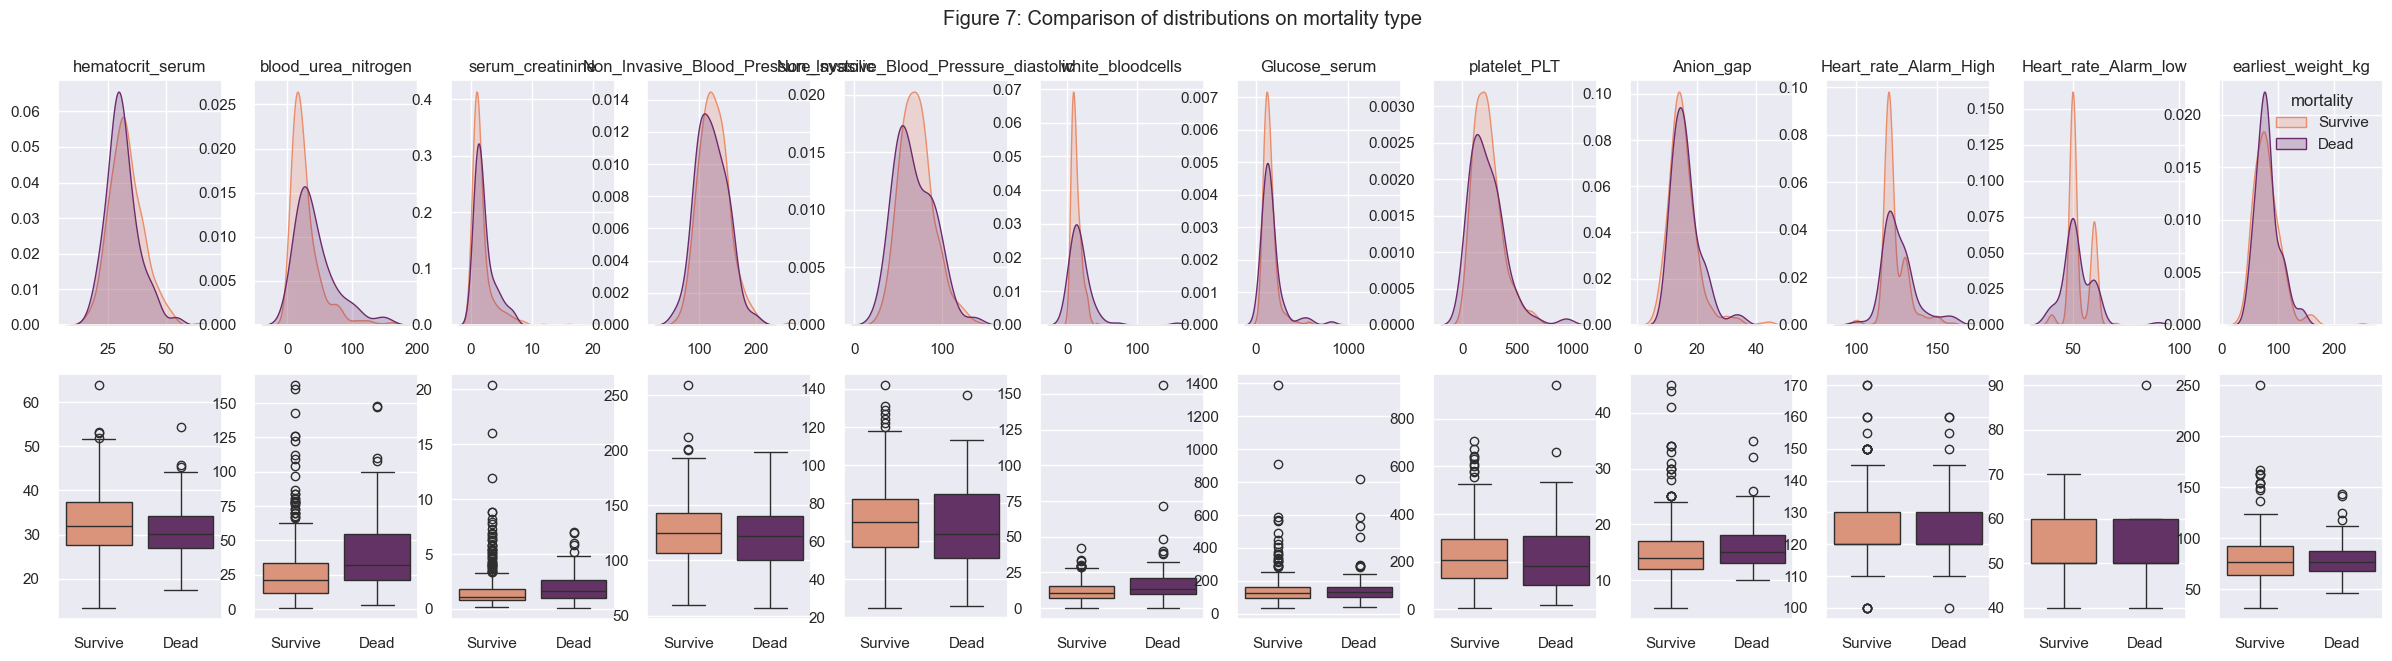

{'hematocrit_serum': 0.08171731362400673,
 'blood_urea_nitrogen': 4.210149937530727e-05,
 'serum_creatinine': 0.24533111239740876,
 'Non_Invasive_Blood_Pressure_systolic': 0.1939779480726459,
 'Non_Invasive_Blood_Pressure_diastolic': 0.26064089863273837,
 'white_bloodcells': 6.520017525397125e-06,
 'Glucose_serum': 0.3400256602017512,
 'platelet_PLT': 0.8964879692361067,
 'Anion_gap': 0.20964132924507364,
 'Heart_rate_Alarm_High': 0.07468042563239233,
 'Heart_rate_Alarm_low': 0.33532058879893656,
 'earliest_weight_kg': 0.7687837322829225}

In [28]:
plot_mean_difference(df_clean, 'mortality', "Figure 7: Comparison of distributions on mortality type", [palette[0], palette[-1]])

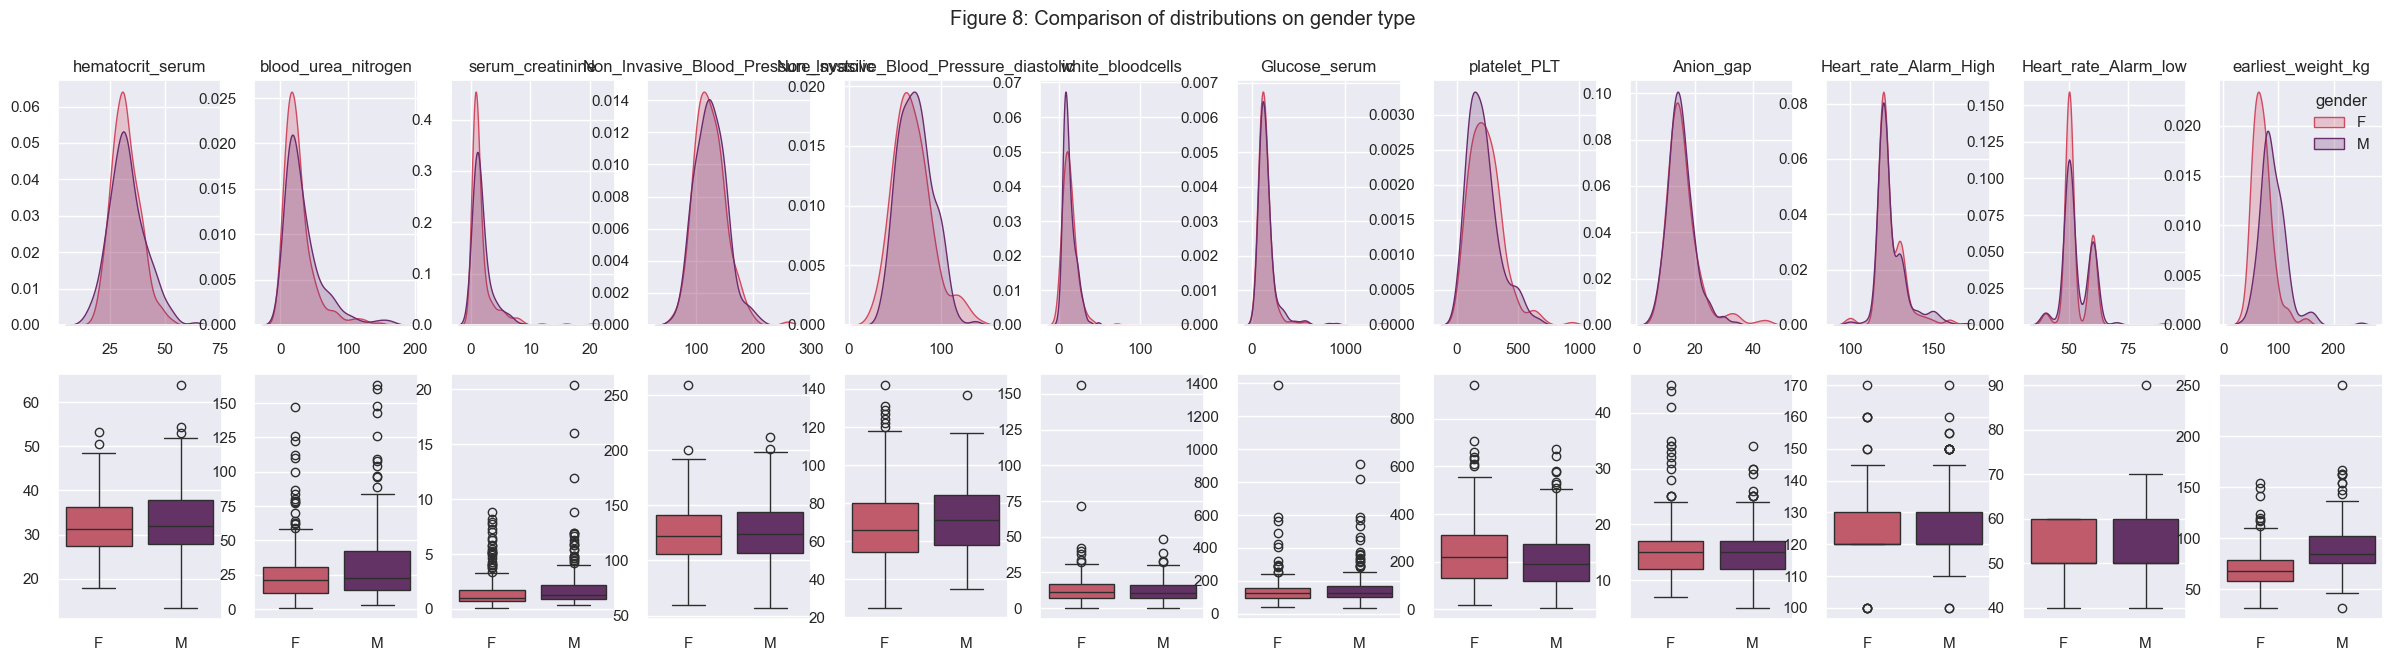

{'hematocrit_serum': 0.354799896320668,
 'blood_urea_nitrogen': 0.008849320654058482,
 'serum_creatinine': 0.04931852846735334,
 'Non_Invasive_Blood_Pressure_systolic': 0.7551469711967109,
 'Non_Invasive_Blood_Pressure_diastolic': 0.09847098120502377,
 'white_bloodcells': 0.29193687090218823,
 'Glucose_serum': 0.3568072142903831,
 'platelet_PLT': 0.06454831823687893,
 'Anion_gap': 0.16173847011087156,
 'Heart_rate_Alarm_High': 0.5783169409584235,
 'Heart_rate_Alarm_low': 0.16216200526667618,
 'earliest_weight_kg': 3.4612492277520454e-17}

In [29]:
plot_mean_difference(df_clean, 'gender', "Figure 8: Comparison of distributions on gender type", [palette[-4], palette[-1]])

# 4. Preprocessing

In [30]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,0,71,31.3,28.0,1.2,158.0,61.0,4.6,127.0,107.0,11.0,125.0,60.0,59.7
1,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,23.0,130.0,40.0,56.0
2,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,14.0,120.0,50.0,78.1
3,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,13.0,150.0,40.0,52.2
4,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,24.0,130.0,50.0,103.4


In [31]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,mortality
0,0,71,31.3,28.0,1.2,158.0,61.0,4.6,127.0,107.0,11.0,125.0,60.0,59.7,0,1
1,0,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,23.0,130.0,40.0,56.0,0,0
2,0,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,14.0,120.0,50.0,78.1,0,1
3,0,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,13.0,150.0,40.0,52.2,0,1
4,0,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,24.0,130.0,50.0,103.4,1,1


In [32]:
X = X.fillna(X.median())

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.34156503,  0.63227332, -0.16515647, ..., -0.8407189 ,
        -0.99009877,  0.43109246],
       [-0.34156503,  1.65077949, -1.73316779, ..., -0.99345179,
        -0.99009877, -2.31968799],
       [-0.34156503,  1.3678611 , -1.37555117, ..., -0.08118235,
        -0.99009877,  0.43109246],
       ...,
       [-0.34156503,  1.31127743, -0.0413661 , ..., -1.07601011,
        -0.99009877,  0.43109246],
       [-0.34156503, -0.55598388, -1.0729525 , ...,  0.04265513,
         1.01000025,  0.43109246],
       [-0.34156503, -0.38623285, -1.23800632, ..., -1.26176634,
         1.01000025,  0.43109246]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [34]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 369


array([[-3.41565026e-01,  6.32273316e-01, -1.65156469e-01, ...,
        -8.40718900e-01, -9.90098766e-01,  4.31092459e-01],
       [-3.41565026e-01,  1.65077949e+00, -1.73316779e+00, ...,
        -9.93451794e-01, -9.90098766e-01, -2.31968799e+00],
       [-3.41565026e-01,  1.36786110e+00, -1.37555117e+00, ...,
        -8.11823488e-02, -9.90098766e-01,  4.31092459e-01],
       ...,
       [-3.41565026e-01,  6.64365550e-02, -1.02645412e-04, ...,
        -7.29265167e-02,  1.01000025e+00, -2.31968799e+00],
       [-3.41565026e-01,  1.31127743e+00, -4.13661012e-02, ...,
        -1.07601011e+00, -9.90098766e-01,  4.31092459e-01],
       [-3.41565026e-01, -5.55983882e-01, -1.07295250e+00, ...,
         4.26551324e-02,  1.01000025e+00,  4.31092459e-01]])

# 5. Clustering


## 5.1. Finding optimal cluster

#### Manual

In [35]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [36]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

13821579.28659204

In [37]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([89.62739355, 90.53134731, 91.20462853, 91.71926673, 92.10725445,
       92.434255  , 92.66916496, 92.85062963, 93.10075434, 93.23925495,
       93.36108048, 93.52630284, 93.62866724])

Text(0.5, 1.0, 'Total Variance Explained')

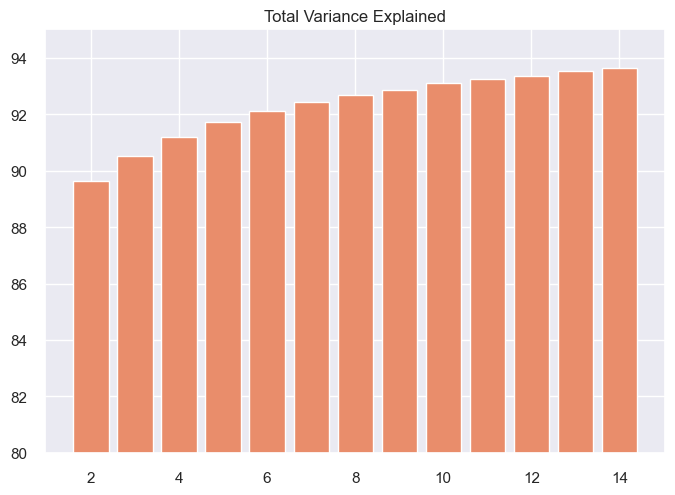

In [38]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

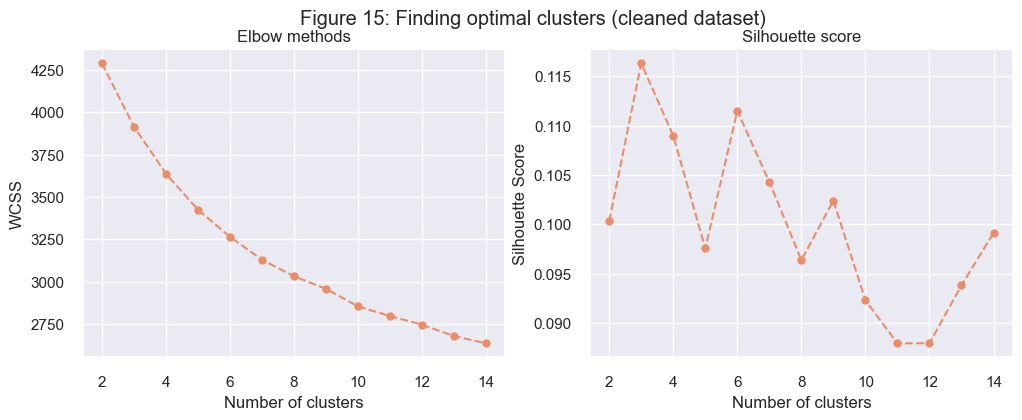

In [39]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 15: Finding optimal clusters (cleaned dataset)")
plt.show()

#### On Yellowbrick

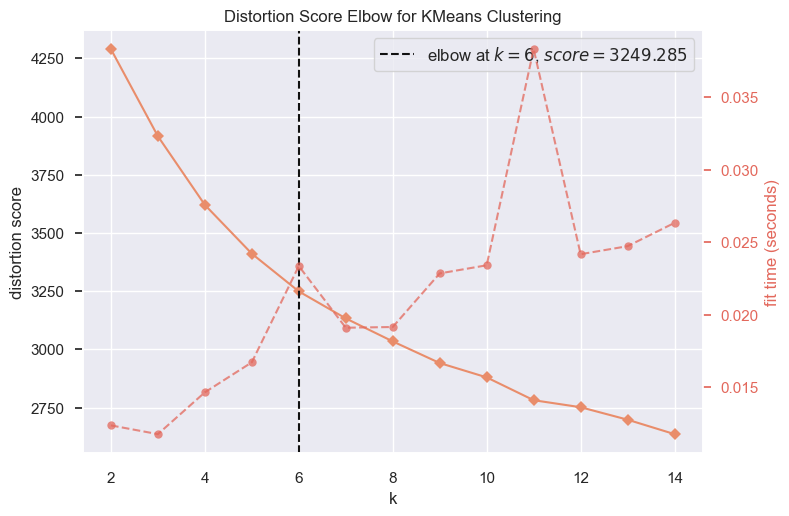

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [41]:
optimal_cluster = 3

## 5.2. Fitting the model

In [42]:
# Fit model
kmeans = KMeans(n_clusters=optimal_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,26100575,0,F,71,31.3,28.0,1.2,158.0,61.0,4.6,127.0,107.0,11.0,125.0,60.0,59.7,Survive,2
1,22698313,0,F,89,19.9,40.0,1.0,107.0,54.0,39.7,240.0,183.0,23.0,130.0,40.0,56.0,Dead,2
2,29562026,0,F,84,22.5,26.0,0.7,118.0,96.0,7.1,116.0,160.0,14.0,120.0,50.0,78.1,Survive,2
3,21607777,0,F,37,29.5,31.0,2.0,76.0,48.0,18.6,106.0,239.0,13.0,150.0,40.0,52.2,Survive,2
4,25233292,0,M,47,29.9,97.0,6.8,137.0,85.0,9.7,110.0,137.0,24.0,130.0,50.0,103.4,Survive,1


In [43]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {optimal_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 3 clusters, resulting on 3915.4 WCSS and 0.12 silhouette score


In [44]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,1.000000e+00,47.105263,34.013158,22.894737,1.465789,124.210526,76.236842,11.218421,149.342105,142.684211,16.763158,126.315789,53.684211,82.407895,0.578947,0.894737
1,8.326673e-17,60.957055,32.939571,32.644172,1.798160,124.300613,71.073620,12.487730,142.852761,221.190184,14.779141,124.171779,52.607362,91.150920,0.969325,0.815951
2,1.110223e-16,62.744048,31.872321,24.684524,1.570238,124.952381,68.648810,12.812500,132.648810,237.000000,14.666667,122.559524,52.470238,68.132143,0.005952,0.886905


## 5.3. Visualization

### Clusters Visualization

In [45]:
cluster_colors = [palette[0], palette[2], palette[-1]]

In [46]:
def stat_cum(cluster):
    cluster0 = df_clean[df_clean.cluster == cluster]
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    display(round(cluster0.describe(),2))

stat_cum(0)

Percentage of women and men (respectively) 42.11 and 57.89


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,38.00,38.0,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.00,37.00,37.00,37.00
mean,25340976.68,1.0,47.11,34.01,22.89,1.47,124.21,76.24,11.22,149.34,142.68,16.76,126.49,53.78,82.55
std,3048592.21,0.0,11.47,8.21,15.57,1.14,26.27,19.94,5.21,60.06,98.27,6.66,8.73,5.45,21.82
min,20561449.00,1.0,27.00,16.90,3.00,0.40,73.00,36.00,2.90,66.00,18.00,7.00,120.00,50.00,51.90
25%,22360649.00,1.0,39.50,28.12,9.50,0.72,107.00,62.50,7.72,105.50,82.50,13.00,120.00,50.00,65.00
50%,25524721.00,1.0,47.00,32.90,20.00,1.05,122.00,76.00,11.25,139.50,127.00,15.50,120.00,50.00,77.20
75%,27956768.75,1.0,54.75,39.78,31.75,1.68,143.00,87.25,14.88,181.00,162.00,18.00,130.00,60.00,94.40
max,29871774.00,1.0,65.00,54.30,67.00,4.60,188.00,127.00,26.70,288.00,487.00,34.00,150.00,70.00,161.90


In [47]:
# Statistical summary of cluster 1
stat_cum(1)

Percentage of women and men (respectively) 3.07 and 96.93


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,163.00,163.0,163.00,162.00,163.00,163.00,163.00,163.00,162.00,163.00,162.00,163.00,163.00,163.00,163.00
mean,25199378.54,0.0,60.96,32.95,32.64,1.80,124.30,71.07,12.50,142.85,221.30,14.78,124.17,52.61,91.15
std,2731678.11,0.0,16.55,7.85,24.03,1.48,27.01,18.39,7.56,74.36,131.98,3.96,8.72,5.62,22.55
min,20084622.00,0.0,22.00,13.40,4.00,0.40,57.00,35.00,0.30,36.00,6.00,5.00,100.00,40.00,50.60
25%,23013952.50,0.0,50.00,27.92,14.00,0.90,104.50,57.00,7.20,100.50,121.25,12.00,120.00,50.00,76.15
50%,25090117.00,0.0,63.00,32.30,23.00,1.30,124.00,70.00,10.75,123.00,205.50,14.00,120.00,50.00,86.00
75%,27521904.50,0.0,72.00,38.05,43.50,2.10,142.50,83.00,16.90,163.50,289.00,17.00,130.00,60.00,104.00
max,29995505.00,0.0,91.00,53.10,112.00,8.80,212.00,137.00,48.60,532.00,645.00,29.00,155.00,70.00,163.00


In [48]:
# Statistical summary of cluster 2
stat_cum(2)

Percentage of women and men (respectively) 99.4 and 0.6


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,white_bloodcells,Glucose_serum,platelet_PLT,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,168.00,168.0,168.00,167.00,168.00,168.00,167.00,167.00,167.00,168.00,167.00,168.00,168.00,168.00,168.00
mean,24511020.61,0.0,62.74,31.87,24.68,1.57,124.96,68.65,12.82,132.65,237.20,14.67,122.56,52.47,68.13
std,2848977.58,0.0,18.68,5.95,19.47,1.66,25.47,20.86,7.75,53.53,118.38,3.90,6.83,5.25,15.86
min,20009550.00,0.0,21.00,19.90,1.00,0.20,60.00,25.00,0.20,58.00,29.00,7.00,100.00,40.00,32.00
25%,21776652.00,0.0,51.75,27.35,12.00,0.70,107.00,55.00,7.20,95.00,144.00,12.00,120.00,50.00,56.75
50%,24538760.00,0.0,64.00,31.20,20.00,0.90,123.00,66.00,11.00,123.00,226.00,14.00,120.00,50.00,66.20
75%,26988386.25,0.0,76.00,35.90,30.00,1.60,141.00,80.00,16.25,151.00,310.50,16.25,125.00,60.00,77.93
max,29742461.00,0.0,91.00,53.20,122.00,8.80,200.00,131.00,42.20,424.00,640.00,30.00,150.00,60.00,123.90


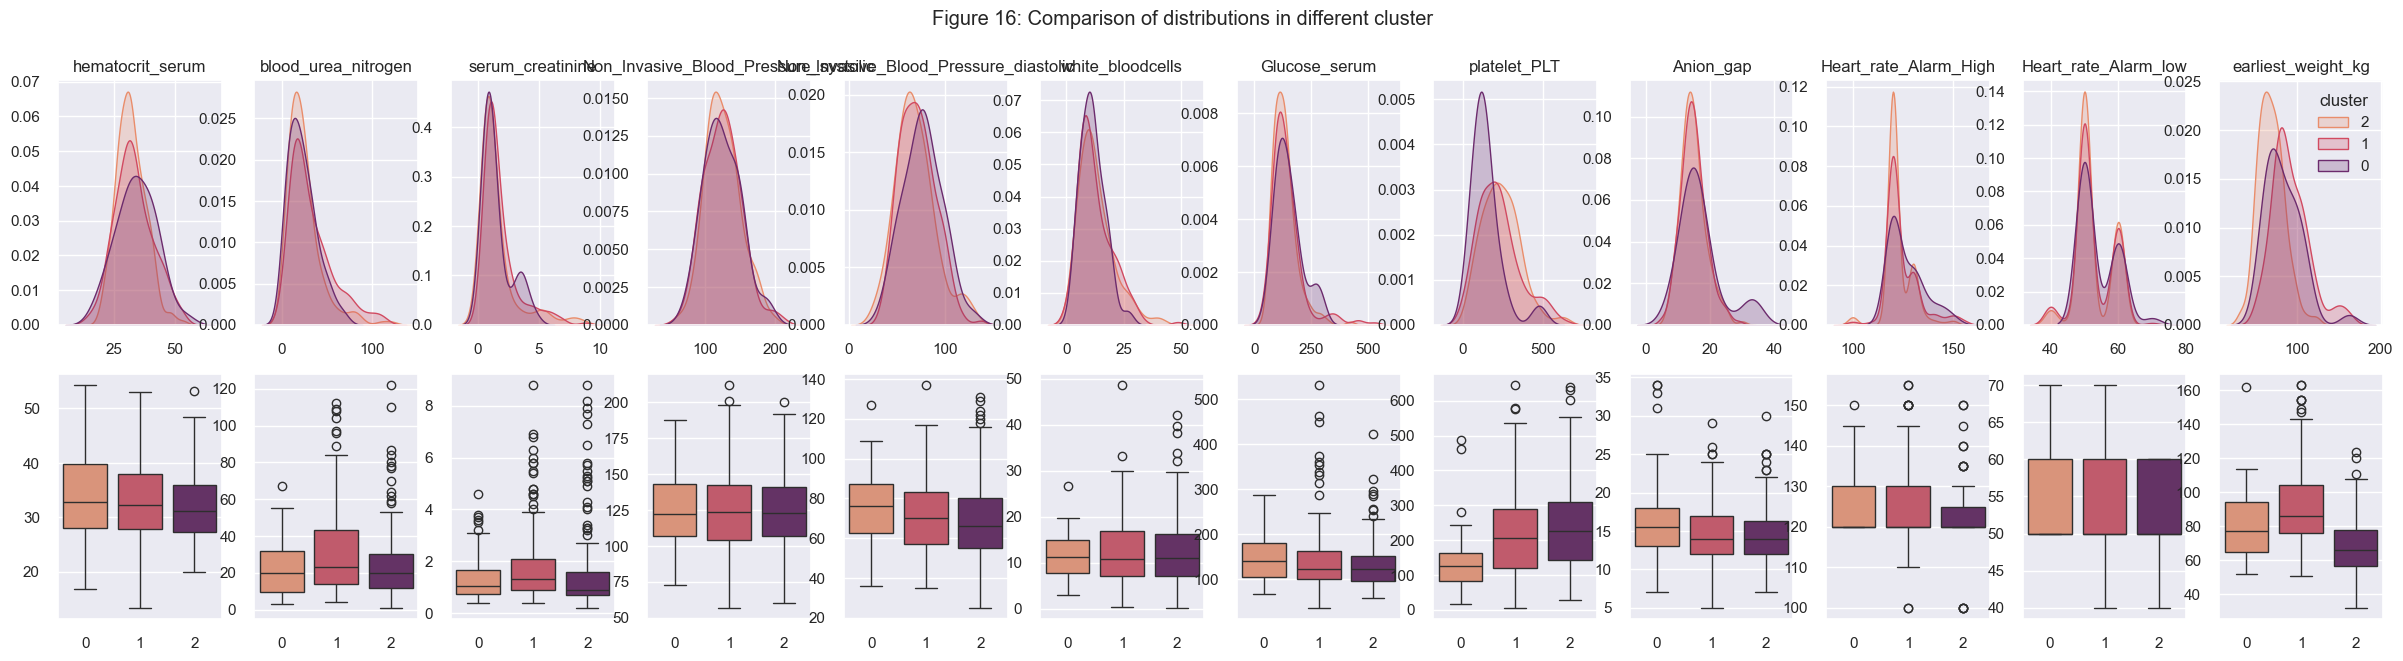

{'hematocrit_serum': 0.16215777816204885,
 'blood_urea_nitrogen': 0.0010163333467934474,
 'serum_creatinine': 0.1891935768747163,
 'Non_Invasive_Blood_Pressure_systolic': 0.818510890630703,
 'Non_Invasive_Blood_Pressure_diastolic': 0.26347031006429633,
 'white_bloodcells': 0.6992818777198412,
 'Glucose_serum': 0.1519613103868011,
 'platelet_PLT': 0.25051894925112644,
 'Anion_gap': 0.794824919221214,
 'Heart_rate_Alarm_High': 0.06160043078172108,
 'Heart_rate_Alarm_low': 0.8186217554900456,
 'earliest_weight_kg': 2.3232157729546227e-23}

In [49]:
plot_mean_difference(df_clean, 'cluster', "Figure 16: Comparison of distributions in different cluster", colours=cluster_colors)

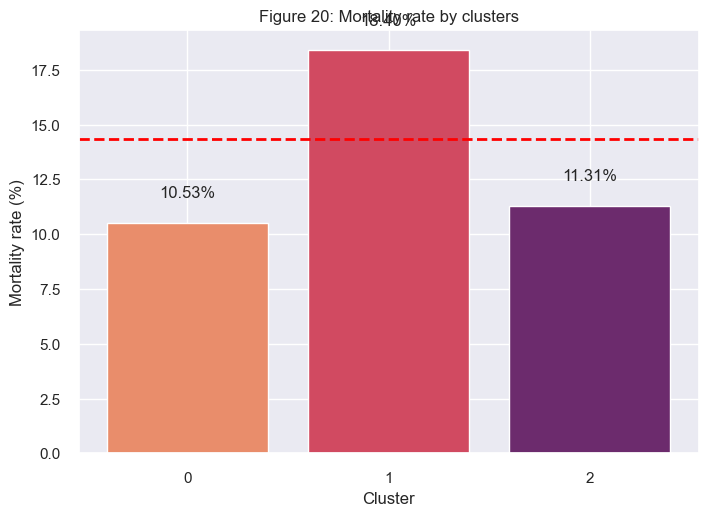

In [50]:
# Mortality rate in each cluster
mortality_cluster = []

for c in sorted(df_clean['cluster'].unique()):
    sub = df_clean[df_clean.cluster == c]
    mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / len(sub))

plt.bar(["0","1","2"], mortality_cluster, color=cluster_colors)
plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Overall 15.67%', xy=(0, 20), xytext=(2.5, 16))

for i, rate in enumerate(mortality_cluster):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

plt.xlabel("Cluster")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 20: Mortality rate by clusters")

plt.show()

### On PCA

In [51]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca['cluster'] = df_clean['cluster']
X_pca

,PC1,PC2,PC3,cluster
0,-1.018693,-0.495870,-0.017991,2
1,-0.017954,3.092263,2.616299,2
2,-0.953606,-0.000747,0.311312,2
3,-0.989590,1.162113,0.243959,2
4,3.406222,1.575806,-1.063236,1
...,...,...,...,...
397,2.243333,1.250839,-0.180107,1
398,0.640916,0.586482,-0.296592,1
399,-1.815553,0.443487,1.571621,2
400,0.833620,1.953836,-0.799405,1


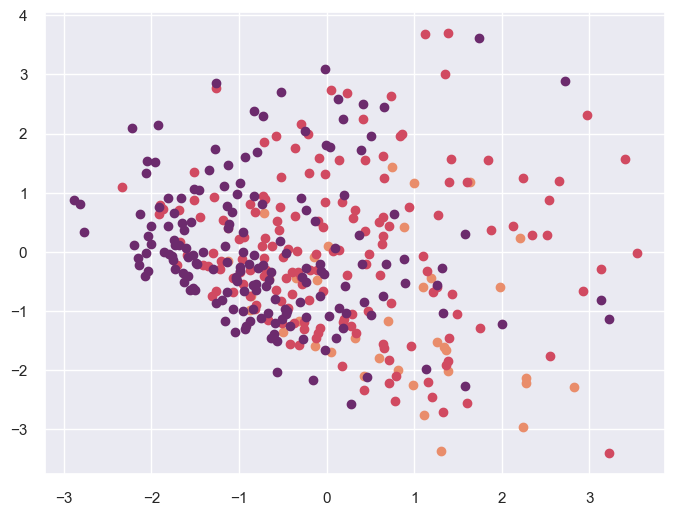

In [53]:
plt.figure(figsize=(8, 6))
for cluster in range(3):
    cluster_data = X_pca[X_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=cluster_colors[cluster])

In [54]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="Figure 12: Age, Comorbidity Index, and APS-III", color_discrete_sequence=cluster_colors)
fig.show()

# 6. Discussion

## 6.1. Property of the clusters

## 6.2. Relation to Outcomes